# Reproduce and extend the A. Destexhe *Neural. Comp* 2009 paper on sustained asynchronous firing in networks of AdEx neurons

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from brian2 import *

In [3]:
import input_factory as inpf

In [4]:
def beautify_spikes(statemon,spikemon,neuron_id):
    vm = statemon[neuron_id].v[:]
    offset = statemon.t[0]#/defaultclock.dt
    dt = statemon.t[1]-statemon.t[0]
    spike_times = spikemon.t[spikemon.i == neuron_id]
    for t in spike_times:
        i = int((t-offset) / dt)
        vm[i] = 20*mV
    return vm

In [5]:
rc('axes',grid=True)

In [6]:
def raster_spikes(spikemon, offset=0, ax=None,color='k'):
    if ax is None:
        f,ax = subplots(1,1)
    ax.plot(spikemon.t/ms, offset+spikemon.i,',',c=color)
    

## AdEx model in Destexhe's formulation

\begin{align}
C_m\frac{dV}{dt} & =   -g_l(V-E_l) + g_l\Delta V\exp(\frac{V-V_T}{\Delta V}) - w/S\\
\tau_w\frac{dw}{dt} & =  a(V-E_l) - w
\end{align}

Здесь можно писать всевозможные объяснения. В том числе **полужирным** и *курсивом*

### Parameters

In [19]:
Cm = 1*uF/cm2
gl = 0.05 *mS/cm2
El = -60 *mV
VT = -50 *mV
Sarea = 20e3*um2
tau_w = 600 *ms
#tau_w = 100 *ms
deltaT = 2.5*mV
Vcut = -20*mV
#Vreset = -55*mV
Vreset = -55*mV

# Synapses
E_e = 0*mV     # Excitatory synaptic reversal potential (AMPA and NMDA receptors)
E_i = -80*mV   # Inhibitory synaptic reversal potential (GABAA receptors)
tau_e = 5*ms   # time scale of excitatory synaptic conductance
tau_i = 10*ms  # time scale of excitatory synaptic conductance


In [20]:
AdEx_equations = Equations('''
dv/dt = (-gl*(v-El) + gl*deltaT*exp((v-VT)/deltaT) - u/Sarea + Isyn/Sarea + Ibias/Sarea + Iapp/Sarea)/Cm : volt (unless refractory)
du/dt = (a*(v-El) - u)/tau_w: amp  # adaptation variable
stim_amp : 1
Ibias : amp
Iapp = stim_amp*input_current(t,i): amp
''')

# Synaptic input
synaptic_equations = Equations("""
Isyn =  -g_e*(v-E_e) - g_i*(v-E_i) : amp
dg_e/dt = -g_e/tau_e : siemens
dg_i/dt = -g_i/tau_i : siemens
""")

In [21]:
PY_pars = dict(a=0.001*uS, b=0.04*nA)
FS_pars = dict(a=0.001*uS, b=0.00*nA)
LTS_pars = dict(a=0.02*uS, b=0.0*nA)
TC_pars = dict(a=0.04*uS, b=0.0*nA)
RE_pars = dict(a=0.03*uS, b=0.08*nA)
RS1_pars = dict(a=0.001*uS, b=0.04*nA)
RS2_pars = dict(a=0.001*uS, b=0.005*nA)            

In [22]:
RS2_pars

{'a': 1. * nsiemens, 'b': 5. * pamp}

## Reproducing Fig. 1

Below we learn to create groups of neurons with specified parameters and run a simulation.

In [23]:
start_scope()

Nneurons = 3

defaultclock.dt = 0.1*ms

G_LTS = NeuronGroup(Nneurons, 
                AdEx_equations+synaptic_equations,
                refractory=2.5*ms,
                namespace=LTS_pars,
                threshold='v>Vcut', 
                reset='v=Vreset; u += b',
                method='exponential_euler')

G_LTS.set_states(dict(v=El,u=0))

G_LTS.stim_amp = (-0.25,0,0.25)
M_LTS = StateMonitor(G_LTS, ['v','u'], record=True)
S_LTS = SpikeMonitor(G_LTS,)

G_RS1 = NeuronGroup(Nneurons, 
                AdEx_equations+synaptic_equations,
                refractory=2.5*ms,
                namespace=RS1_pars,
                threshold='v>Vcut', 
                reset='v=Vreset; u += b',
                method='exponential_euler')

G_RS1.set_states(dict(v=El,u=0))

G_RS1.stim_amp = (-0.25,0,0.25)
M_RS1 = StateMonitor(G_RS1, ['v','u'], record=True)
S_RS1 = SpikeMonitor(G_RS1,)

G_RS2 = NeuronGroup(Nneurons, 
                AdEx_equations+synaptic_equations,
                namespace=RS2_pars,
                threshold='v>Vcut', 
                refractory=2.5*ms,
                reset='v=Vreset; u += b',
                method='exponential_euler')

G_RS2.set_states(dict(v=El,u=0))

G_RS2.stim_amp = (-0.25,0,0.25)
M_RS2 = StateMonitor(G_RS2, ['v','u'], record=True)
S_RS2 = SpikeMonitor(G_RS2,)

G_FS = NeuronGroup(Nneurons, 
                AdEx_equations+synaptic_equations,
                namespace=FS_pars,
                refractory=2.5*ms,
                threshold='v>Vcut', 
                reset='v=Vreset; u += b',
                method='exponential_euler')

G_FS.set_states(dict(v=El,u=0))

G_FS.stim_amp = (-0.25,0,0.25)
M_FS = StateMonitor(G_FS, ['v','u'], record=True)
S_FS = SpikeMonitor(G_FS,)

G_TC = NeuronGroup(Nneurons, 
                AdEx_equations+synaptic_equations,
                namespace=TC_pars,
                threshold='v>Vcut', 
                reset='v=Vreset; u += b',
                refractory=2.5*ms,
                method='exponential_euler')

G_TC.set_states(dict(v=El,u=0))

G_TC.stim_amp = (-0.25,0,0.25)
M_TC = StateMonitor(G_TC, ['v','u'], record=True)
S_TC = SpikeMonitor(G_TC,)

G_RE = NeuronGroup(Nneurons, 
                AdEx_equations+synaptic_equations,
                namespace=RE_pars,
                threshold='v>Vcut', 
                reset='v=Vreset; u += b',
                refractory=2.5*ms,
                method='exponential_euler')

G_RE.set_states(dict(v=El,u=0))

G_RE.stim_amp = (-0.25,0,0.25)
M_RE = StateMonitor(G_RE, ['v','u'], record=True)
S_RE = SpikeMonitor(G_RE,)


In [24]:
input_current = inpf.get_step_current(200, 700, 1*ms, 1.0*nA,Nneurons=Nneurons)

In [25]:
store()

In [26]:
restore()

In [27]:
%time run(1.5*second)

CPU times: user 5.76 s, sys: 83.9 ms, total: 5.84 s
Wall time: 15.8 s


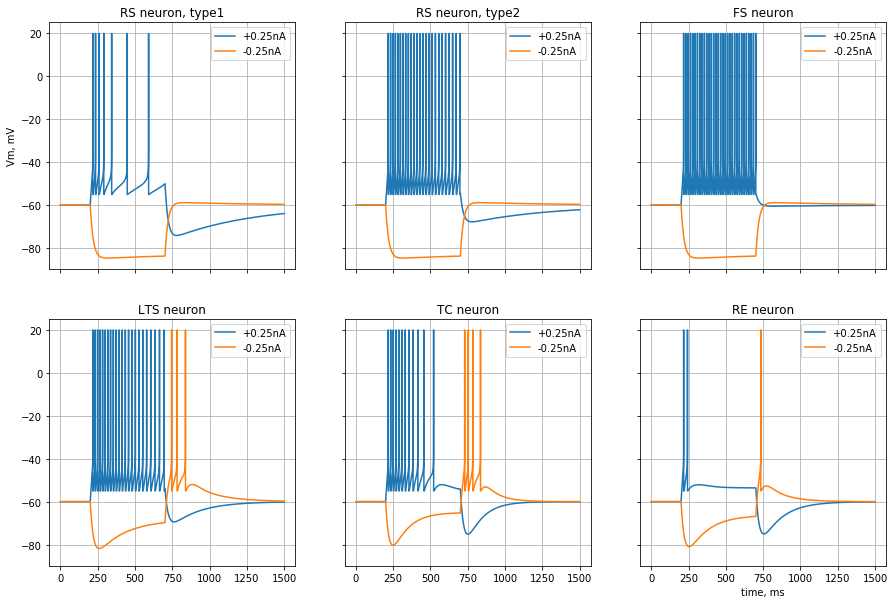

In [28]:
f, axs = subplots(2,3,sharex=True,sharey=True,figsize=(15,10))

axs[0,0].plot(M_RS1.t/ms, beautify_spikes(M_RS1,S_RS1,2)/mV,label='+0.25nA')
axs[0,0].plot(M_RS1.t/ms, beautify_spikes(M_RS1,S_RS1,0)/mV,label='-0.25nA')
axs[0,0].set_title("RS neuron, type1")
axs[0,0].legend()

axs[0,1].plot(M_RS2.t/ms, beautify_spikes(M_RS2,S_RS2,2)/mV,label='+0.25nA')
axs[0,1].plot(M_RS2.t/ms, beautify_spikes(M_RS2,S_RS2,0)/mV,label='-0.25nA')
axs[0,1].set_title("RS neuron, type2")
axs[0,1].legend()

axs[0,2].plot(M_FS.t/ms, beautify_spikes(M_FS,S_FS,2)/mV,label='+0.25nA')
axs[0,2].plot(M_FS.t/ms, beautify_spikes(M_FS,S_FS,0)/mV,label='-0.25nA')
axs[0,2].set_title("FS neuron")
axs[0,2].legend()

axs[1,0].plot(M_LTS.t/ms, beautify_spikes(M_LTS,S_LTS,2)/mV,label='+0.25nA')
axs[1,0].plot(M_LTS.t/ms, beautify_spikes(M_LTS,S_LTS,0)/mV,label='-0.25nA')
axs[1,0].set_title("LTS neuron")
axs[1,0].legend()

axs[1,1].plot(M_TC.t/ms, beautify_spikes(M_TC,S_TC,2)/mV,label='+0.25nA')
axs[1,1].plot(M_TC.t/ms, beautify_spikes(M_TC,S_TC,0)/mV,label='-0.25nA')
axs[1,1].set_title("TC neuron")
axs[1,1].legend()

axs[1,2].plot(M_RE.t/ms, beautify_spikes(M_RE,S_RE,2)/mV,label='+0.25nA')
axs[1,2].plot(M_RE.t/ms, beautify_spikes(M_RE,S_RE,0)/mV,label='-0.25nA')
axs[1,2].set_title("RE neuron")
axs[1,2].legend()

#title('Regular spiking (pyramidal) neuron')
xlabel('time, ms'); axs[0,0].set_ylabel('Vm, mV');


Итак, нейроны классов LTS, TC и RE демонстрируют спайки в ответ на снятие гиперполяризующего тока, <font color=red>потому что...</font>

## Networking

Для начала определим ряд параметров и уравнений для описания событий, связанных со спайками в пресинаптическом нейроне, вероятностью выброса кванта нейромедиатора и пластичности.

In [29]:
tau_ps = 0.8*second   # facilitation timescale
tau_ns = 1.5*second   # replenishing timescale
tau_stdp = 20*ms     # STDP time constant

p_s0 = 1.0            # Start with no facilitation
p_s0 = 0.8            # Start with some facilitation
#p_s0 = 0.6           # ground-state probability of release
depletion_amount = 0.0  # no depression; change in 0...1 interval
stdp_amount = 0 # change between 0 and 1



epsilon = 0.02        # sparsity synaptic connectivity

Apre0 = 0.01
Apost0 = -Apre0*1.05

w_e = 6*nS
w_i = 67*nS

w_ext = 3*nS





tm_plasticity_model = Equations('''
dp_s/dt = (p_s0-p_s)/tau_ps : 1 (event-driven)    # release probability
dn_s/dt = (1-n_s)/tau_ns   : 1    (event-driven)  # fraction of resources available
''')

stdp_model=Equations('''
dApre/dt = -Apre/tau_stdp : 1 (event-driven)    # STDP
dApost/dt = -Apost/tau_stdp : 1(event-driven)   # STDP
w_syn: 1
''')

tm_action_pre='''
p_s += p_s0*(1-p_s) # facilitation
r_s = p_s*n_s       # probability of release
n_s -= depletion_amount*r_s          # depletion

'''

stdp_action_pre='''
Apre += Apre0
'''

stdp_action_post='''
Apost += Apost0
'''


pre_actions_e = '''
w_syn = clip(w_syn+Apost, (1-stdp_amount)*w_e/nS, w_e/nS) 
g_e_post += w_syn*r_s*nS
'''
pre_actions_i = '''
w_syn = clip(w_syn+Apost, (1-stdp_amount)*w_i/nS, w_i/nS) 
g_i_post += w_syn*r_s*nS
'''

post_actions_e='''
w_syn = clip(w_syn+Apre,(1-stdp_amount)*w_e/nS,w_e/nS)
'''

post_actions_i='''
w_syn = clip(w_syn+Apre,(1-stdp_amount)*w_i/nS,w_i/nS)
'''

## Reproducing Fig. 7

Попробуем собрать сеть из RS, LTS и FS нейронов. Первые два класса будут образовывать возбуждающие синапсы, последний класс будет описывать интернейроны и давать тормозящие синапсы.

Но сначала нам нужно создать группу "как-бы нейронов", которые будут выдавать ПД в случайные моменты времени в течение заданного периода. Этим мы будем моделировать внешние возбуждающие связи, необходимые для затравки собственной сетевой активности.

In [31]:
def transient_PoissonGroup(N, rate, start_ms, stop_ms):
    thr = 'rand()<rates*dt and t<{stop}*ms and t >={start}*ms'.format(start=start_ms, stop=stop_ms)
    g = NeuronGroup(N, 'rates : Hz', threshold=thr)
    g.rates = rate
    return g


In [32]:
shared_kwargs = dict(
                 threshold='v>Vcut', 
                 refractory=2.5*ms,
                 reset='v=Vreset; u += b',
                 method='exponential_euler')

In [33]:
start_scope()

defaultclock.dt = 0.1*ms

exc_fraction = 0.8
lts_fraction = 0.1

Ntotal = 1000
Nin = int((1-exc_fraction)*Ntotal)             # inhibitory neurons (interneurons, aka fast spiking)
Nrs = int(exc_fraction*(1-lts_fraction)*Ntotal)        # regular spiking pyramidal neurons
Nlts = int(exc_fraction*lts_fraction*Ntotal)        # low-threshold spiking pyramidal neurons

prob_scale = 2000/Ntotal

P = transient_PoissonGroup(100, 200/second, 50, 250)
Pspikes = SpikeMonitor(P,record=True)


Gin = NeuronGroup(Nin, AdEx_equations+synaptic_equations,
                  namespace = FS_pars, **shared_kwargs)
Gin.set_states(dict(v=El, u=0))

Min = StateMonitor(Gin,['v','g_e'],record=True,dt=0.5*ms)
Sin = SpikeMonitor(Gin, record=True)

Glts = NeuronGroup(Nlts, AdEx_equations+synaptic_equations,
                   namespace=LTS_pars,
                   **shared_kwargs)
Glts.set_states(dict(v=El, u=0))

Mlts = StateMonitor(Glts,['v','g_e','g_i'],record=True,dt=0.5*ms)
Slts = SpikeMonitor(Glts, record=True)

Grs = NeuronGroup(Nrs, AdEx_equations+synaptic_equations,
                 namespace=RS2_pars,
                 **shared_kwargs)
Grs.set_states(dict(v=El, u=0))
Mrs = StateMonitor(Grs,['v','g_e','g_i'],record=True, dt=0.5*ms)
Srs = SpikeMonitor(Grs, record=True)

In [34]:
Nrs,Nlts,Nin

(720, 80, 199)

In [35]:
## Excitatory synapses

# External input

S_ext = Synapses(P, Grs, on_pre='g_e_post += w_ext')

exc_syn_args = dict(model=tm_plasticity_model+stdp_model,
                    on_pre=tm_action_pre+stdp_action_pre+pre_actions_e,
                    on_post=stdp_action_post+post_actions_e)
                   

inh_syn_args = dict(model=tm_plasticity_model+stdp_model,
                    on_pre=tm_action_pre+stdp_action_pre+pre_actions_i,
                    on_post=stdp_action_post+post_actions_i)
# From RS
S_rs_rs = Synapses(Grs, Grs, **exc_syn_args)
S_rs_lts = Synapses(Grs, Glts,**exc_syn_args)
S_rs_in = Synapses(Grs, Gin, **exc_syn_args)

# From LTS
S_lts_rs = Synapses(Glts, Grs, **exc_syn_args)
S_lts_lts = Synapses(Glts, Glts, **exc_syn_args)
S_lts_in = Synapses(Glts, Gin, **exc_syn_args)

# From FS
S_in_rs = Synapses(Gin, Grs, **inh_syn_args)
S_in_lts = Synapses(Gin, Glts, **inh_syn_args)
S_in_in = Synapses(Gin, Gin, **inh_syn_args)

In [36]:
epsilon*prob_scale

0.04

In [37]:
%%time 

S_ext.connect(p=0.005)

S_rs_rs.connect('i!=j',p=epsilon*prob_scale)
S_rs_lts.connect(p=epsilon*prob_scale)
S_rs_in.connect(p=epsilon*prob_scale)

S_lts_rs.connect(p=epsilon*prob_scale)
S_lts_lts.connect('i!=j',p=epsilon*prob_scale)
S_lts_in.connect(p=epsilon*prob_scale)

excitatory_synapses = [S_rs_rs,S_rs_lts,S_rs_in,
                       S_lts_rs,S_lts_lts,S_lts_in]

S_in_rs.connect(p=epsilon*prob_scale)
S_in_lts.connect(p=epsilon*prob_scale)
S_in_in.connect('i!=j',p=epsilon*prob_scale)

inhibitory_synapses = [S_in_rs, S_in_lts, S_in_in]
cortical_connections = excitatory_synapses+inhibitory_synapses

CPU times: user 147 ms, sys: 3.97 ms, total: 151 ms
Wall time: 150 ms


In [38]:
cortical_net = Network(P, Gin, Grs, Glts, Mrs, Srs, Mlts, Slts, Min,Sin, Pspikes,
                       S_ext, *cortical_connections)

In [39]:
input_current = inpf.get_step_current(200, 700, 1*ms, 1.0*nA,Nneurons=Ntotal)

In [40]:
cortical_net.store()

`>>>>> Start over simulation from here <<<<<`

К этой ячейке нужно возвращаться, чтобы поменять такие параметры как задержка между нейронами, наличие фасилитации или депрессии в пресинаптической мембране и STDP.

In [44]:
cortical_net.restore() # "вспоминаем сохраненное состояние" 

In [45]:
p_s0 = 1.0               # ground-state probability of release; change in 0...1 interval to allow for facilitation
depletion_amount = 0.00  # depression amount; change in 0...1 interval; increase for depressing synapses
stdp_amount = 0.0        # STDP amount; change between 0 and 1

In [46]:
average_delay = 3*ms             # средняя синаптическая задержка (фактически, определяется длиной аксона)
delay_jitter = 0.5*average_delay # разброс задержек. Здесь, полностью случайный

In [47]:
for s in cortical_connections:
    s.delay = "average_delay-0.5*delay_jitter + delay_jitter*rand()"  # delays in synapses.
    s.p_s = p_s0
    s.n_s = 1.0

In [48]:
%%time 

cortical_net.run(3*second, report='text') # три секунды модельного времени. У меня считает около 2 минут.

Starting simulation at t=0. s for a duration of 3. s
2.3465 s (78%) simulated in 10s, estimated 3s remaining.
3. s (100%) simulated in 12s
CPU times: user 1min 6s, sys: 471 ms, total: 1min 7s
Wall time: 1min 37s


In [49]:
#mean([Mrs.v[i].max() for i in range(Nrs)])

In [50]:
k=randint(Nrs)

(0, 2999.5)

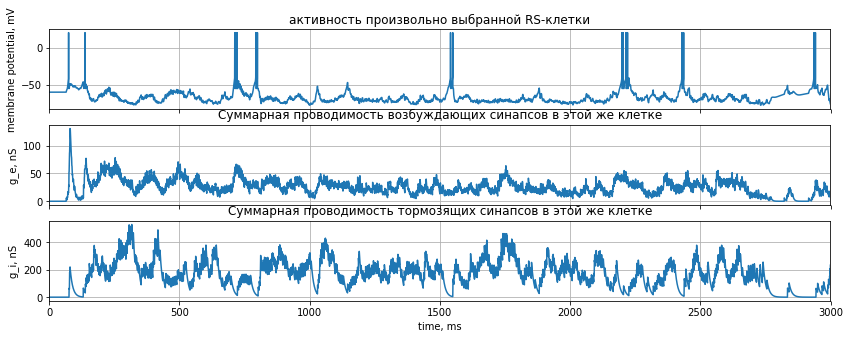

In [51]:
f, axs = subplots(3,1, sharex=True, figsize=(14,5))

axs[0].plot(Mrs.t/ms, beautify_spikes(Mrs,Srs,k)/mV)

axs[0].set_ylabel('membrane potential, mV')
axs[0].set_title('активность произвольно выбранной RS-клетки')

axs[1].plot(Mrs.t/ms, Mrs.g_e[k]/nS)
axs[1].set_ylabel('g_e, nS')
axs[1].set_title('Суммарная проводимость возбуждающих синапсов в этой же клетке')

axs[2].plot(Mrs.t/ms, Mrs.g_i[k]/nS)
axs[2].set_ylabel('g_i, nS')
axs[2].set_title('Суммарная проводимость тормозящих синапсов в этой же клетке')
#xlim(200,400)
xlabel('time, ms'); 
xlim(0,Mrs.t[-1]/ms)


(-100, 1000)

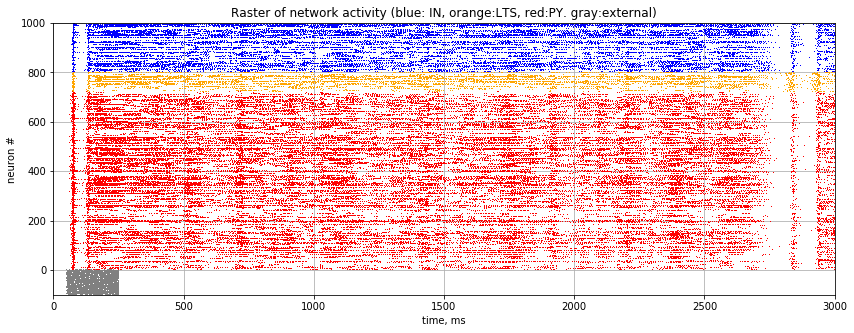

In [52]:
f,ax = subplots(1,1,figsize=(14,5))


raster_spikes(Pspikes,ax=ax,color='gray',offset=-100)
raster_spikes(Srs,ax=ax,color='red',offset=0)
raster_spikes(Slts,ax=ax,color='orange',offset=0+Nrs)
raster_spikes(Sin,ax=ax,color='blue',offset=0+Nrs+Nlts)

title('Raster of network activity (blue: IN, orange:LTS, red:PY. gray:external)')
xlabel('time, ms')
ylabel('neuron #')
xlim(0,Mrs.t[-1]/ms)
ylim(-100,Ntotal)

<font color='red'>**Вопросы:**
   1. Как зависит наличие самоподдерживающейся активности от средней синаптической задержки? Оцените длину аксона, соответствующую задержке в 10 мс.
   1. Как зависит наличие самоподдерживающейся активности от разброса синаптических задержек?
   2. Как зависит наличие самоподдерживающейся активности от наличия синаптической фасилитации ($p_s0 < 1$)?
   2. Как зависит наличие самоподдерживающейся активности от наличия синаптической депрессии?
   3. Как активность сети от вклада механизма STDP?
                                                                                                          
    

In [53]:
def get_mean_CV(spikemon):
    active_cells = unique(spikemon.i)
    acc = []
    for i in active_cells:
        spike_times = spikemon.t[spikemon.i==i]
        if len(spike_times)>10:
            isi_v = diff(spike_times/ms)
            acc.append(std(isi_v)/mean(isi_v))
    return mean(acc)

In [54]:
get_mean_CV(Srs), get_mean_CV(Sin)

(1.8012195180619281, 1.6800724809030774)

In [55]:
def get_spike_counts(spikemon, neuronid,start_time=0*ms,stop_time=3*second, bin_size=5*ms):
    spike_times = spikemon.t[spikemon.i==neuronid]
    acc = [((spike_times>=start)*(spike_times<start+bin_size)).sum() for
          start in arange(start_time,stop_time-bin_size,bin_size)]
    return array(acc)

In [56]:
def spike_count_entropy(spike_counts):
    N = len(spike_counts)
    probs = [sum(spike_counts==i)/N for i in range(0,max(spike_counts))]
    return -sum(p*log2(p) for p in probs)
    

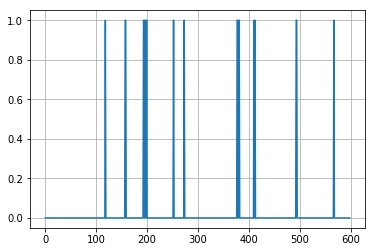

In [57]:
x=get_spike_counts(Srs,10)
plot(x)

In [58]:
spike_count_entropy(x)

0.04502804609154204